In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Load data

On connaît l'âge et l'expérience d'une personne, on veut pouvoir déduire si une personne est badass dans son domaine ou non.

In [3]:
df = pd.DataFrame({
    'Age': [20,16.2,20.2,18.8,18.9,16.7,13.6,20.0,18.0,21.2,
           25,31.2,25.2,23.8,23.9,21.7,18.6,25.0,23.0,26.2],
    'Experience': [2.3,2.2,1.8,1.4,3.2,3.9,1.4,1.4,3.6,4.3,
            4.3,4.2,3.8,3.4,5.2,5.9,3.4,3.4,5.6,6.3],
    'Badass': [0,0,0,0,0,0,0,0,0,0,
            1,1,1,1,1,1,1,1,1,1]
})
df

,Age,Experience,Badass
0,20.0,2.3,0
1,16.2,2.2,0
2,20.2,1.8,0
3,18.8,1.4,0
4,18.9,3.2,0
5,16.7,3.9,0
6,13.6,1.4,0
7,20.0,1.4,0
8,18.0,3.6,0
9,21.2,4.3,0


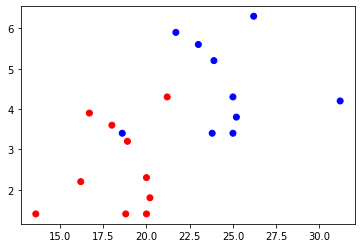

In [4]:
colors = np.full_like(df['Badass'], 'red', dtype='object')
colors[df['Badass'] == 1] = 'blue'

plt.scatter(df['Age'], df['Experience'], color=colors)

In [5]:
X = df.drop('Badass', axis=1).values
Y = df['Badass'].values

In [6]:
# Cas à prédire
x = [21.2, 4.3]

## Using sklearn

### Fit

In [7]:
from sklearn.linear_model import LogisticRegression

In [8]:
model = LogisticRegression(C=1e20, solver='liblinear', random_state=0)
%time model.fit(X, Y)

CPU times: user 7.7 ms, sys: 0 ns, total: 7.7 ms
Wall time: 6.07 ms


LogisticRegression(C=1e+20, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [9]:
print(model.intercept_, model.coef_)

[-18.825058] [[0.7151625 1.0549935]]


### Plot Decision Boundary

<details>
    <summary>Where does the equation come from? ↓</summary>
    <img src="https://i.imgur.com/YxSDJZA.png?1">
</details>

In [10]:
b0 = model.intercept_[0]
b1 = model.coef_[0][0]
b2 = model.coef_[0][1]

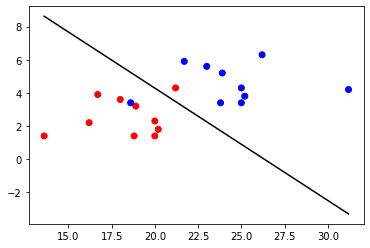

In [11]:
plt.scatter(df['Age'], df['Experience'], color=colors)

# Decision boundary (with threshold 0.5)
_X = np.linspace(df['Age'].min(), df['Age'].max(),10)
_Y = (-b1/b2)*_X + (-b0/b2)

plt.plot(_X, _Y, '-k')

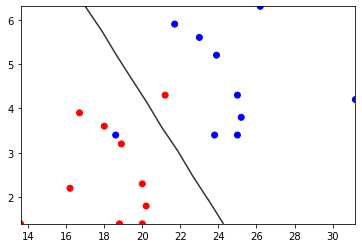

In [12]:
# Plot using contour
_X1 = np.linspace(df['Age'].min(), df['Age'].max(),10)
_X2 = np.linspace(df['Experience'].min(), df['Experience'].max(),10)

xx1, xx2 = np.meshgrid(_X1, _X2)
grid = np.c_[xx1.ravel(), xx2.ravel()]
preds = model.predict_proba(grid)[:, 1].reshape(xx1.shape)

plt.scatter(df['Age'], df['Experience'], color=colors)
plt.contour(xx1, xx2, preds, levels=[.5], cmap="Greys", vmin=0, vmax=.6)

### Predict

In [13]:
print('Probabilité de badass:', model.predict_proba([x])[0][1])
print('Prediction:', model.predict([x])[0])

Probabilité de badass: 0.7053402697503758
Prediction: 1


## From scratch

### Fit

Source: https://github.com/martinpella/logistic-reg/blob/master/logistic_reg.ipynb

In [14]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [15]:
def loss(h, y):
    return (-y * np.log(h) - (1 - y) * np.log(1 - h)).mean()

In [16]:
def gradientDescent(X, y, theta, alpha, epochs, verbose=True):
    m = len(y)

    for i in range(epochs):
        h = sigmoid(X.dot(theta))

        gradient = (X.T.dot(h - y)) / m
        theta   -= alpha * gradient

        if(verbose and i % 1000 == 0):
            z = np.dot(X, theta)
            h = sigmoid(z)
            print('loss:', loss(h, y))

    return theta

In [17]:
# Add intercept
m  = len(X)
b  = np.ones((m,1))
Xb = np.concatenate([b, X], axis=1)

# Fit
theta = np.random.rand(3)
theta = gradientDescent(Xb, Y, theta=theta, alpha=0.1, epochs=10000)
theta

loss: 1.124180592736419
loss: 2.926929160297942
loss: 2.7773598334658973
loss: 2.601273225890172
loss: 2.28331100018835
loss: 1.6858248502625137
loss: 1.3059903426752117
loss: 0.27310846657132865
loss: 0.2449326702085412
loss: 0.24245990459602784


array([-29.12111127,   1.20616178,   1.05921078])

### Plot

In [18]:
b0 = theta[0]
b1 = theta[1]
b2 = theta[2]

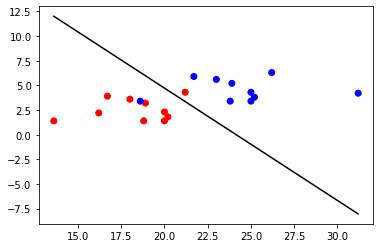

In [19]:
plt.scatter(df['Age'], df['Experience'], color=colors)

# Decision boundary (with threshold 0.5)
_X = np.linspace(df['Age'].min(), df['Age'].max(),10)
_Y = (-b1/b2)*_X + (-b0/b2)

plt.plot(_X, _Y, '-k')

### Predict

In [20]:
z  = b0 + b1 * x[0] + b2 * x[1]
p  = 1 / (1 + np.exp(-z))

print('Probabilité de badass:', p)
print('Prediction:', (1 if p > 0.5 else 0))

Probabilité de badass: 0.7318688005720919
Prediction: 1
